# Final training and testing using the full MNIST-fashion dataset

In [1]:
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from copy import deepcopy
import seaborn as sns
import itertools
import copy
import autograd.numpy as np
import pandas as pd
from tqdm import tqdm

from activation_functions import *
from cost_functions import *
from FFNN import *

# Setting the random seed
np.random.seed(3155)

### Library used for selecting the right fontsize wrt revtex4 in LaTeX

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Widths in inches from revtex4's layout
# Single column ~3.375in, double column ~7in
columnwidth = 3.375  # use 7.0 for two-column-wide figures

# Compute figure size (width, height)
fig_width = columnwidth
fig_height = columnwidth / 1.618  # golden ratio for aesthetics
fig_size = [fig_width, fig_height]

mpl.rcParams.update({
    # Use LaTeX for text rendering
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],  # empty means use LaTeX default (Computer Modern)
    "font.size": 14.0, 

    # Adjust tick and label sizes
    "axes.labelsize": 14.0,
    "legend.fontsize": 12.0,
    "xtick.labelsize": 12.0,
    "ytick.labelsize": 12.0,

    # Figure dimensions
    "figure.figsize": fig_size,

    # Save with good resolution
    "savefig.dpi": 300,
})

## Import and preprocessing of data

In [3]:
# Fetch the Fashion-MNIST dataset
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
# Extract data (features) and target (labels)
X = mnist.data
y = mnist.target

# Scaling the pixel values from 0-255 to 0-1
X = X / 255.0

In [4]:
# Splitting the data into testing, training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)


In [5]:
# Define parameters
layer_output_size = [500, 10]
eta = 0.01
activation_funcs = [sigmoid, softmax]
epochs = 100

# Setting L2 lambda
l2_lmbda = 0.00001

network_input_size = X_train.shape[1]

In [22]:
# Create network
NN_baseline = NeuralNetwork(network_input_size, layer_output_size, activation_funcs, cross_entropy)

In [23]:
NN_reg_l2 = NeuralNetwork(network_input_size, layer_output_size, activation_funcs, cross_entropy, l1_lambda=0, l2_lambda=l2_lmbda)
NN_reg_l2.layers = copy.deepcopy(NN_baseline.layers)

## Baseline Model

In [7]:
# Store results across all runs
baseline_all_runs_results = []

    
for epoch in range(1, epochs + 1):
    # Training network
    train_network_SRMSprop(NN_baseline, X_train, y_train, eta=eta, epochs=1)
    
    # Get predictions
    train_pred = NN_baseline.predict(X_train)
    test_pred = NN_baseline.predict(X_test)
    
    # Compute accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    # Calculate overfitting gap
    overfit_gap = train_acc - test_acc
    
    # Store results
    baseline_all_runs_results.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfit_gap': overfit_gap
    })
    
    # Print progress every 25 epochs
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")


# Convert to DataFrame
df_baseline_all_runs = pd.DataFrame(baseline_all_runs_results)

df_baseline_all_runs.to_csv(r"Classification_CSV_Results/MNIST_fashion-full_results.csv", index=False)

Epoch 1: Train Acc = 0.7467, Test Acc = 0.7816


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),


Epoch 25: Train Acc = 0.8271, Test Acc = 0.8216
Epoch 50: Train Acc = 0.8392, Test Acc = 0.7873


c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)


Epoch 75: Train Acc = 0.1001, Test Acc = 0.0996
Epoch 100: Train Acc = 0.1001, Test Acc = 0.0996


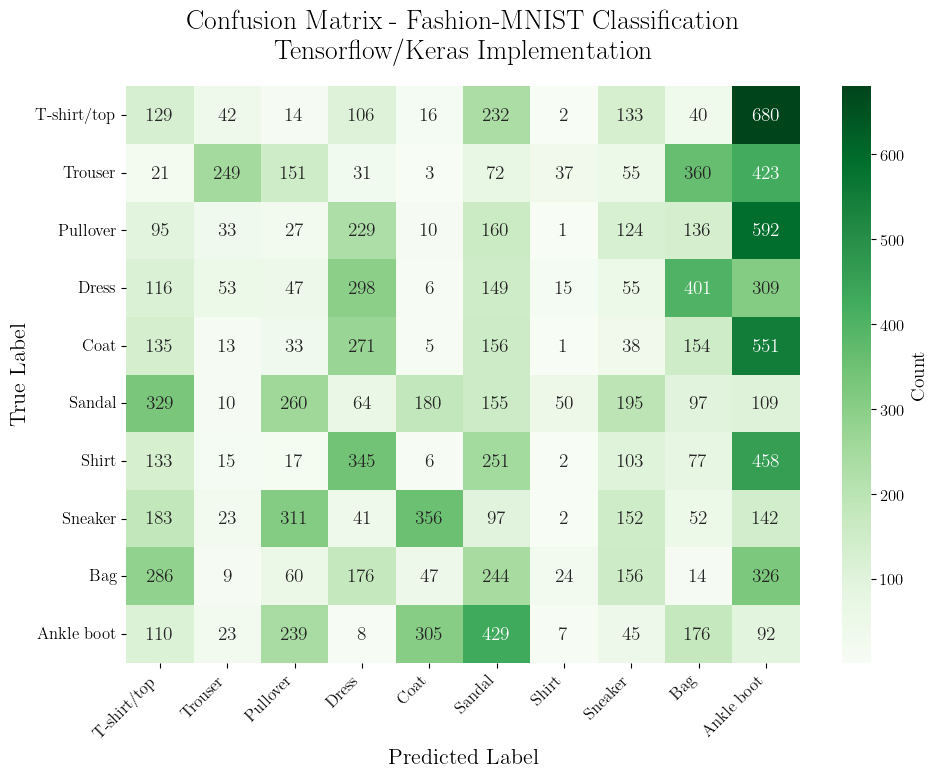

In [24]:
# Convert predictions to class labels if needed
if y_test.ndim == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

y_pred = NN_baseline.predict(X_test)

if y_pred.ndim == 2:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Greens", 
            cbar_kws={'label': 'Count'},
            xticklabels=class_names,
            yticklabels=class_names)
ax.set_title("Confusion Matrix - Fashion-MNIST Classification\nTensorflow/Keras Implementation", 
             fontsize=20, pad=20)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# Load the results from CSV
df_results_baseline = pd.read_csv(r"Classification_CSV_Results/MNIST_fashion-full_results.csv")

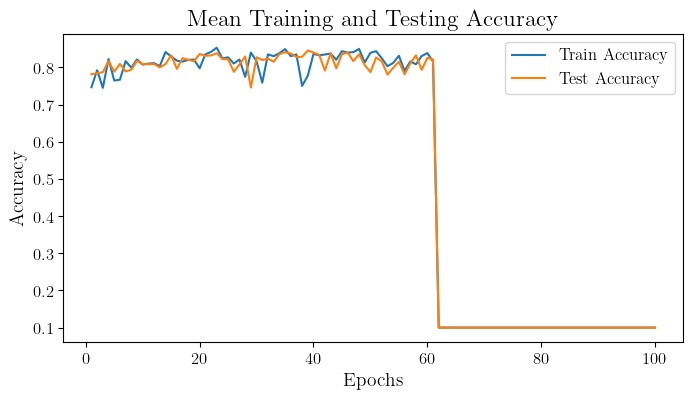

In [10]:
# Plot mean accuracy
plt.figure(figsize=(8, 4))
plt.plot(df_results_baseline['epoch'], df_results_baseline['train_acc'], label='Train Accuracy')
plt.plot(df_results_baseline['epoch'], df_results_baseline['test_acc'], label='Test Accuracy')
plt.title(f'Mean Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

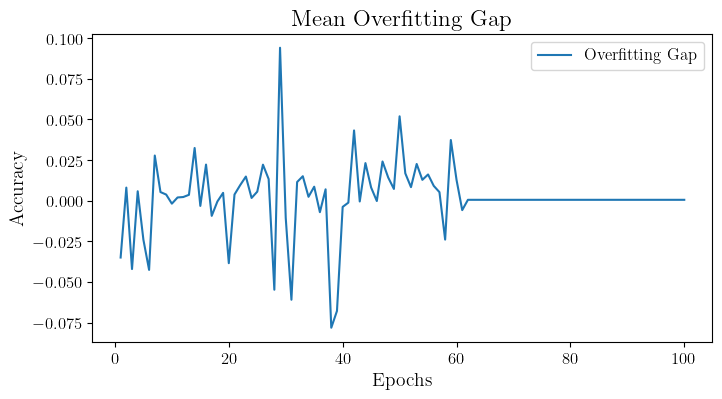

In [11]:
# Plot mean overfitting gap
plt.figure(figsize=(8, 4))
plt.plot(df_results_baseline['epoch'], df_results_baseline['overfit_gap'], label='Overfitting Gap')
plt.title(f'Mean Overfitting Gap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Baseline with Regularization

In [33]:
# Store results across all runs
reg2_all_runs_results = []

for epoch in range(1, epochs + 1):
    # Training network
    train_network_SRMSprop(NN_reg_l2, X_train, y_train, eta=eta, epochs=1)
    
    # Get predictions
    train_pred = NN_reg_l2.predict(X_train)
    test_pred = NN_reg_l2.predict(X_test)
    
    # Compute accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    # Calculate overfitting gap (important for regularization analysis!)
    overfit_gap = train_acc - test_acc
    
    # Store results
    reg2_all_runs_results.append({
        'epoch': epoch,
        'lambda2': l2_lmbda,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfit_gap': overfit_gap
    })
    
    # Print progress every 50 epochs
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}, Gap = {overfit_gap:.4f}")

# Convert to DataFrame
df_reg2_all_runs = pd.DataFrame(reg2_all_runs_results)

df_reg2_all_runs.to_csv(r"Classification_CSV_Results/MNIST_fashion-full_reg_results.csv", index=False)

Epoch 1: Train Acc = 0.7593, Test Acc = 0.7489, Gap = 0.0104
Epoch 25: Train Acc = 0.8279, Test Acc = 0.8218, Gap = 0.0061
Epoch 50: Train Acc = 0.8302, Test Acc = 0.8216, Gap = 0.0086
Epoch 75: Train Acc = 0.8270, Test Acc = 0.8098, Gap = 0.0172
Epoch 100: Train Acc = 0.8227, Test Acc = 0.8086, Gap = 0.0141


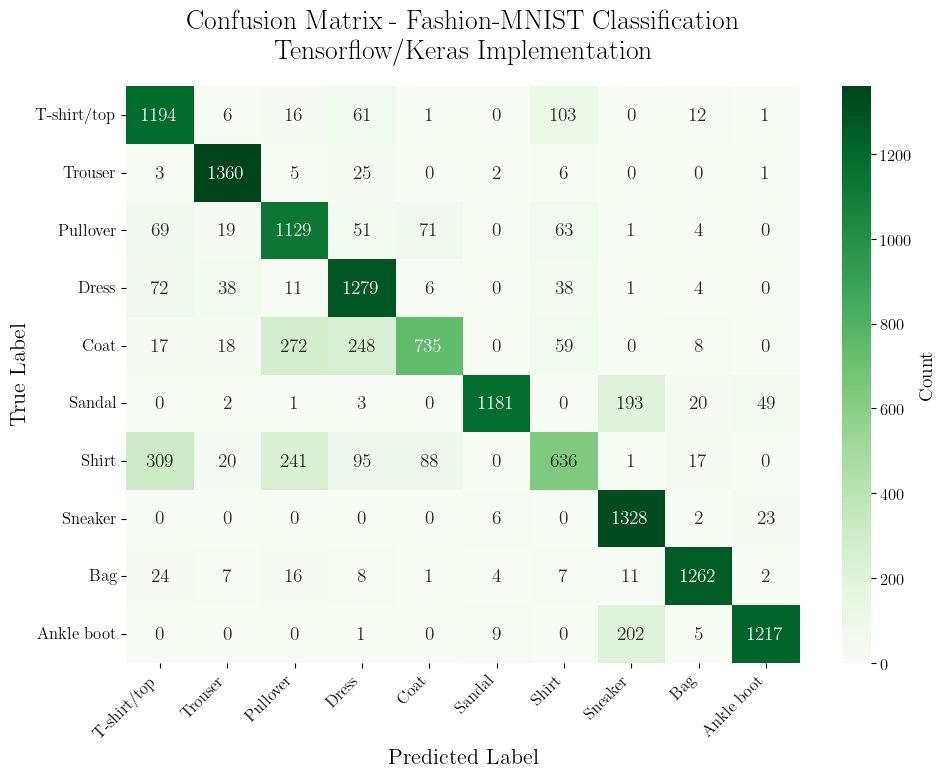

In [38]:
# Convert predictions to class labels if needed
if y_test.ndim == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

y_pred = NN_reg_l2.predict(X_test)

if y_pred.ndim == 2:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Greens", 
            cbar_kws={'label': 'Count'},
            xticklabels=class_names,
            yticklabels=class_names)
ax.set_title("Confusion Matrix - Fashion-MNIST Classification\nTensorflow/Keras Implementation", 
             fontsize=20, pad=20)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
# Load the results from CSV
df_results_reg = pd.read_csv(r"Classification_CSV_Results/MNIST-full_reg_results.csv")

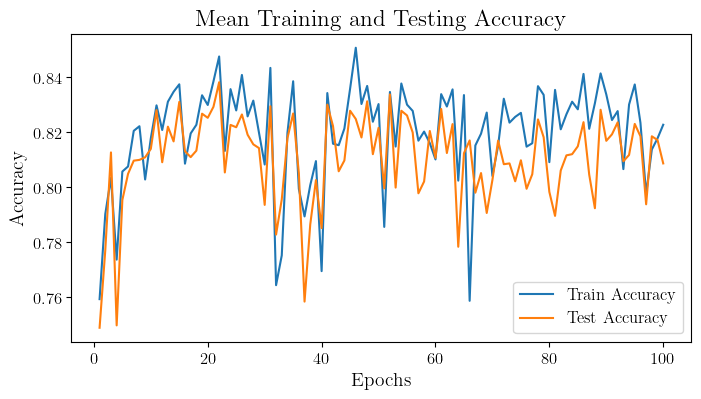

In [40]:
# Plot mean accuracy
plt.figure(figsize=(8, 4))
plt.plot(df_results_reg['epoch'], df_results_reg['train_acc'], label='Train Accuracy')
plt.plot(df_results_reg['epoch'], df_results_reg['test_acc'], label='Test Accuracy')
plt.title(f'Mean Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

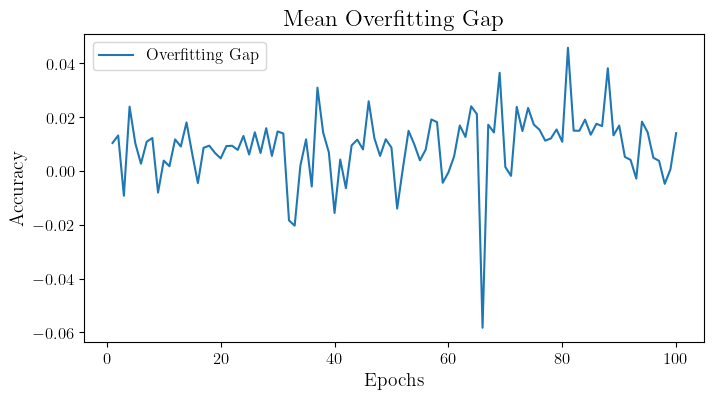

In [41]:
# Plot mean overfitting gap
plt.figure(figsize=(8, 4))
plt.plot(df_results_reg['epoch'], df_results_reg['overfit_gap'], label='Overfitting Gap')
plt.title(f'Mean Overfitting Gap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Tensorflow baseline

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert one-hot encoded labels back to integer labels for Keras
y_train_keras = np.argmax(y_train, axis=1)
y_test_keras = np.argmax(y_test, axis=1)

# Define parameters matching implementation
epochs = 100
eta = 0.01

# Store results
keras_all_runs_results = []

# Create model matching architecture: 784 -> 500 -> 10
# NO regularization
model = keras.Sequential([
    layers.Dense(500, activation='sigmoid', 
                 input_shape=(X_train.shape[1],)),
    layers.Dense(10, activation='softmax')
])

# Use RMSprop optimizer to match train_network_SRMSprop
optimizer = keras.optimizers.RMSprop(learning_rate=eta)

# Compile model with categorical crossentropy
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for one epoch at a time to track progress like implementation
for epoch in range(1, epochs + 1):
    # Train for 1 epoch
    history = model.fit(
        X_train, y_train_keras,
        epochs=1,
        verbose=0,
        validation_data=(X_test, y_test_keras)
    )
    
    # Get accuracy
    train_acc = history.history['accuracy'][0]
    test_acc = history.history['val_accuracy'][0]
    
    # Calculate overfitting gap
    overfit_gap = train_acc - test_acc
    
    # Store results
    keras_all_runs_results.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfit_gap': overfit_gap
    })
    
    # Print progress every 25 epochs
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# Convert to DataFrame
df_keras_all_runs = pd.DataFrame(keras_all_runs_results)
df_keras_all_runs.to_csv(r"Classification_CSV_results/MNIST_fashion-full_Keras_results.csv", index=False)

print("\nKeras Results (No Regularization):")
print(df_keras_all_runs.head(10))

c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Train Acc = 0.7905, Test Acc = 0.8119
Epoch 25: Train Acc = 0.8486, Test Acc = 0.8176
Epoch 50: Train Acc = 0.8624, Test Acc = 0.8415
Epoch 75: Train Acc = 0.8749, Test Acc = 0.8523
Epoch 100: Train Acc = 0.8825, Test Acc = 0.8565

Keras Results (No Regularization):
   epoch  train_acc  test_acc  overfit_gap
0      1   0.790482  0.811929    -0.021446
1      2   0.826679  0.826000     0.000679
2      3   0.827125  0.797143     0.029982
3      4   0.829750  0.809000     0.020750
4      5   0.829482  0.828643     0.000839
5      6   0.831714  0.820500     0.011214
6      7   0.833536  0.852214    -0.018679
7      8   0.833982  0.807786     0.026196
8      9   0.834143  0.847500    -0.013357
9     10   0.841821  0.801500     0.040321


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


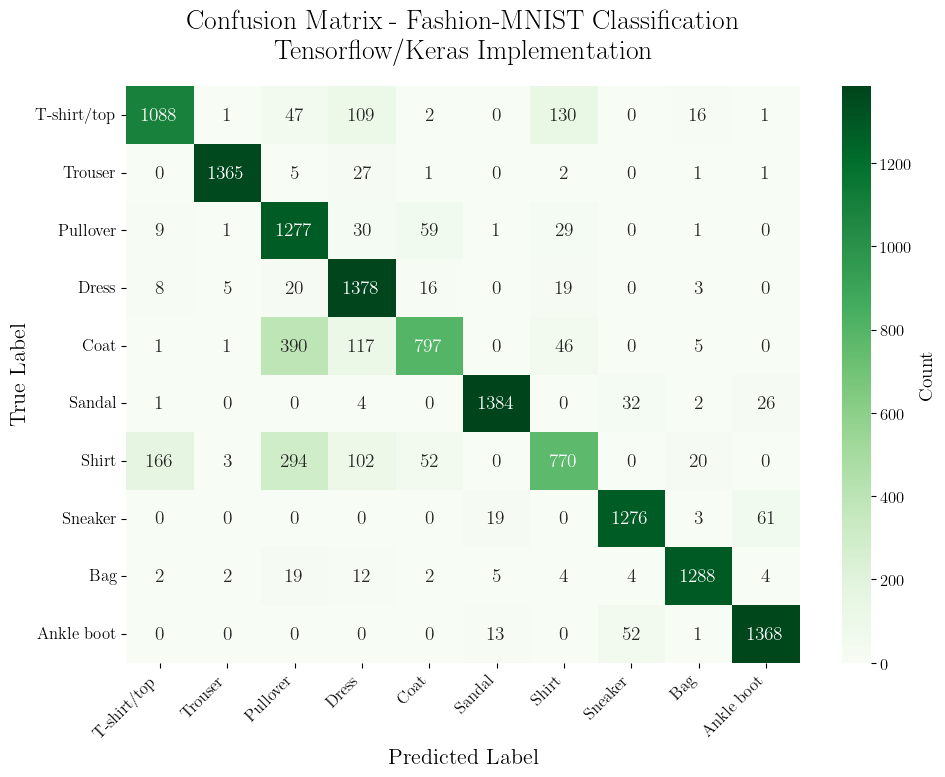

In [30]:
# Convert predictions to class labels if needed
if y_test.ndim == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

y_pred = model.predict(X_test)

if y_pred.ndim == 2:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Greens", 
            cbar_kws={'label': 'Count'},
            xticklabels=class_names,
            yticklabels=class_names)
ax.set_title("Confusion Matrix - Fashion-MNIST Classification\nTensorflow/Keras Implementation", 
             fontsize=20, pad=20)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Tensorflow with L2 regularization

In [14]:
## With reg
# Define parameters matching implementation
epochs = 100
eta = 0.01
l2_lmbda = 0.00001

# Store results across all runs
keras_all_runs_results = []


# Create model matching architecture: 784 -> 500 -> 10
model2 = keras.Sequential([
    layers.Dense(500, activation='sigmoid', 
                    input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(l2_lmbda)),
    layers.Dense(10, activation='softmax',
                    kernel_regularizer=regularizers.l2(l2_lmbda))
])

# Use RMSprop optimizer to match train_network_SRMSprop
optimizer = keras.optimizers.RMSprop(learning_rate=eta)

# Compile model with categorical crossentropy
model2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for one epoch at a time to track progress like implementation
for epoch in range(1, epochs + 1):
    # Train for 1 epoch
    history = model2.fit(
        X_train, y_train_keras,
        epochs=1,
        verbose=0,
        validation_data=(X_test, y_test_keras)
    )
    
    # Get accuracy
    train_acc = history.history['accuracy'][0]
    test_acc = history.history['val_accuracy'][0]
    
    # Calculate overfitting gap
    overfit_gap = train_acc - test_acc
    
    # Store results
    keras_all_runs_results.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfit_gap': overfit_gap
    })
    
    # Print progress every 25 epochs
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# Convert to DataFrame
df_keras_all_runs_reg = pd.DataFrame(keras_all_runs_results)

# Save as CSV
df_keras_all_runs_reg.to_csv(r"Classification_CSV_Results/MNIST_fashion-full_Keras_reg_results.csv", index=False)

c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Train Acc = 0.7829, Test Acc = 0.8208
Epoch 25: Train Acc = 0.8533, Test Acc = 0.8427
Epoch 50: Train Acc = 0.8511, Test Acc = 0.8367
Epoch 75: Train Acc = 0.8449, Test Acc = 0.8262
Epoch 100: Train Acc = 0.8465, Test Acc = 0.8419


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


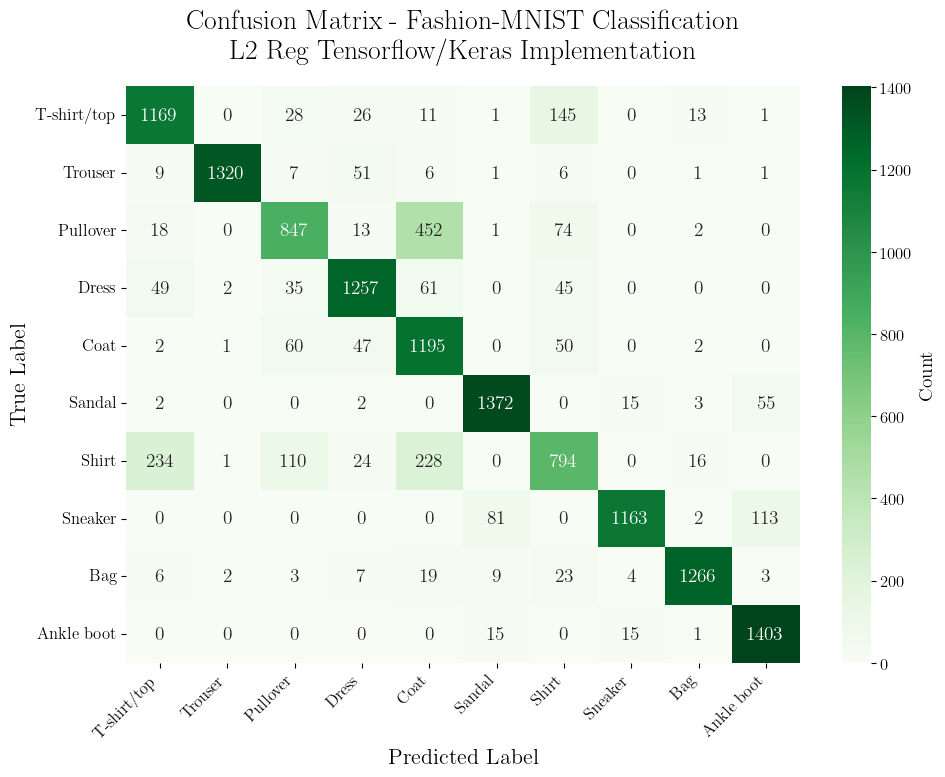

In [32]:
# Convert predictions to class labels if needed
if y_test.ndim == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

y_pred = model2.predict(X_test)

if y_pred.ndim == 2:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Greens", 
            cbar_kws={'label': 'Count'},
            xticklabels=class_names,
            yticklabels=class_names)
ax.set_title("Confusion Matrix - Fashion-MNIST Classification\nL2 Reg Tensorflow/Keras Implementation", 
             fontsize=20, pad=20)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Comparison viz

In [44]:
# Read CSV data
df_results_baseline = pd.read_csv(r"Classification_CSV_Results/MNIST_fashion-full_results.csv")
df_results_reg = pd.read_csv(r"Classification_CSV_Results/MNIST_fashion-full_reg_results.csv")
df_results_keras_baseline = pd.read_csv(r"Classification_CSV_Results/MNIST_fashion-full_Keras_results.csv")
df_results_keras_reg = pd.read_csv(r"Classification_CSV_Results/MNIST_fashion-full_Keras_reg_results.csv")

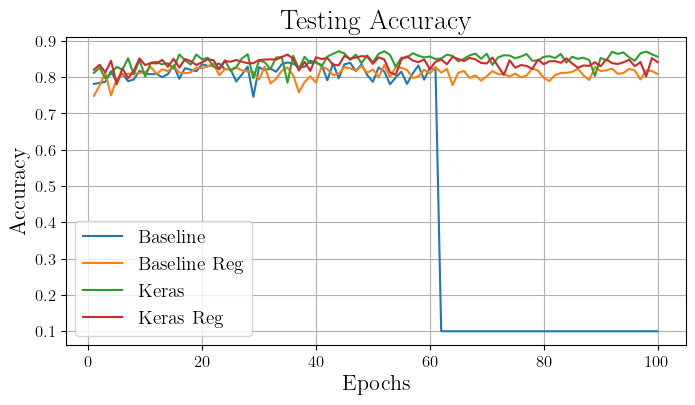

In [46]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(df_results_baseline['epoch'], df_results_baseline['test_acc'], label='Baseline')
plt.plot(df_results_reg['epoch'], df_results_reg['test_acc'], label='Baseline Reg')
plt.plot(df_results_keras_baseline['epoch'], df_results_keras_baseline['test_acc'], label='Keras')
plt.plot(df_results_keras_reg['epoch'], df_results_keras_reg['test_acc'], label='Keras Reg')
plt.title(f'Testing Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

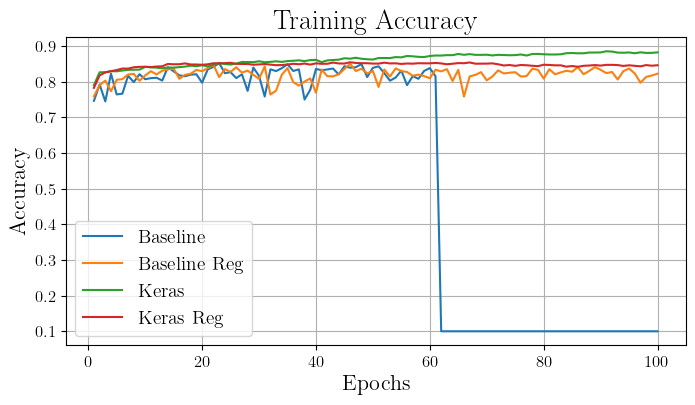

In [47]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(df_results_baseline['epoch'], df_results_baseline['train_acc'], label='Baseline')
plt.plot(df_results_reg['epoch'], df_results_reg['train_acc'], label='Baseline Reg')
plt.plot(df_results_keras_baseline['epoch'], df_results_keras_baseline['train_acc'], label='Keras')
plt.plot(df_results_keras_reg['epoch'], df_results_keras_reg['train_acc'], label='Keras Reg')
plt.title(f'Training Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

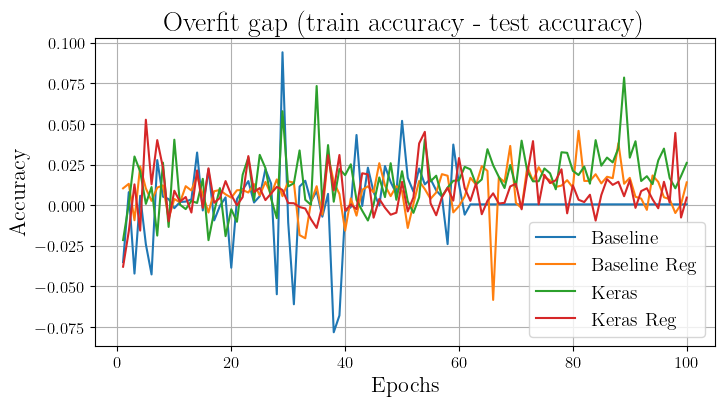

In [48]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(df_results_baseline['epoch'], df_results_baseline['overfit_gap'], label='Baseline')
plt.plot(df_results_reg['epoch'], df_results_reg['overfit_gap'], label='Baseline Reg')
plt.plot(df_results_keras_baseline['epoch'], df_results_keras_baseline['overfit_gap'], label='Keras')
plt.plot(df_results_keras_reg['epoch'], df_results_keras_reg['overfit_gap'], label='Keras Reg')
plt.title(f'Overfit gap (train accuracy - test accuracy)', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()